# First experiments with GANs

In [ ]:
import torch
import torch.nn as nn
from torch.nn.modules.conv import ConvTranspose2d
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np




device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
batch_size=32

Get MNIST dataset : 

In [ ]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       #transforms.Normalize((0.1307,), (0.3081,)), 
                       transforms.Normalize((0.5, ), (0.5, )),
                   ])),
    batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       #transforms.Normalize((0.1307,), (0.3081,))
                       transforms.Normalize((0.5, ), (0.5, )),
                   ])),
    batch_size=batch_size, shuffle=True)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [ ]:
print(len(train_loader))
print(len(test_loader))



1875
313


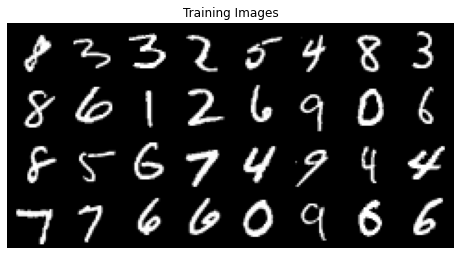

In [ ]:
# Plot some training images
real_batch = next(iter(train_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [ ]:
print(next(iter(train_loader))[0].shape)

torch.Size([32, 1, 28, 28])


Defining Convolutional and TConv blocks 

In [ ]:
class ConvTblock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride,
                 padding):
        super(ConvTblock, self).__init__()
        self.block = nn.Sequential(
            nn.ConvTranspose2d(in_channels,
                               out_channels,
                               kernel_size,
                               stride,
                               padding,
                               bias=False), nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2))

    def forward(self, x):
        return self.block(x)


class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride,
                 padding):
        super(ConvBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels,
                      out_channels,
                      kernel_size,
                      stride,
                      padding,
                      bias=False), nn.BatchNorm2d(out_channels), nn.LeakyReLU(0.2))

    def forward(self, x):
        return self.block(x)



# Generator:

z_c = size of the input vector
hidden_c * factor = channels of the hidden vectors
img_c = channels of the output image




In [ ]:
class Generator(nn.Module):
    def __init__(self, z_c, hidden_c, img_c, factors=[8, 4, 1]):
        super(Generator, self).__init__()

        self.in_block = ConvTblock(z_c, hidden_c * factors[0], 4, 1, 0)
        self.up_blocks = nn.ModuleList([
            ConvTblock(hidden_c * factors[i], hidden_c * factors[i + 1], 4, 2,
                       1) for i in range(len(factors) - 1)
        ])
        self.out_block = nn.Sequential(ConvTranspose2d(hidden_c * factors[-1], img_c, 4, 2,
                                         3), nn.Tanh())

    def forward(self, x):
        #print("Input size : ", x.shape)
        x = self.in_block(x)
        #print(" y in_block size : ", x.shape)
        for block in self.up_blocks:
            x = block(x)
            #print(" y block size : ", x.shape)

        x = self.out_block(x)
        #print(" out size : ", x.shape)

        return x


## Discriminator:
img_c = input image channels
hidden_c * factors = hidden vectors channels 

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, img_c, hidden_c, factors=[1, 4, 8]):
        super(Discriminator, self).__init__()

        self.in_block = nn.Sequential(
            nn.Conv2d(img_c,
                      hidden_c * factors[0],
                      kernel_size=4,
                      stride=2,
                      padding=1),
            nn.LeakyReLU(0.2),
        )
        self.down_blocks = nn.ModuleList([
            ConvBlock(hidden_c * factors[i],
                      hidden_c * factors[i + 1],
                      kernel_size=4,
                      stride=2,
                      padding=1) for i in range(len(factors) - 1)
        ])

        self.out_block = nn.Conv2d(hidden_c * factors[-1],
                                   1,
                                   kernel_size=2,
                                   stride=2,
                                   padding=0)  # size N x 1 x 1 x 1

    def forward(self, x):
        #print("Input size : ", x.shape)
        x = self.in_block(x)
        #print("y in block : ", x.shape)
        for block in self.down_blocks:
            x = block(x)
            #print("y size block : ", x.shape)
        x = self.out_block(x)
        #print("y out block : ", x.shape)
        return torch.sigmoid(x)

Weight initialization: 

In [ ]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)


In [ ]:
def test_dims():
    N, z_dim, H, W = 8, 100, 1, 1
    x = torch.randn((N, z_dim, H, W))
    gen = Generator(z_dim, hidden_c=128, img_c=1, factors=[12, 4, 1])
    initialize_weights(gen)
    assert gen(x).shape == (N, 1, 28, 28)

    N, in_channels, H, W = 8, 1, 28, 28
    x = torch.randn((N, in_channels, H, W))
    disc = Discriminator(in_channels, hidden_c=8, factors=[1, 4, 12])
    initialize_weights(disc)
    assert disc(x).shape == (N, 1, 1, 1)


test_dims()

# Training: 

In [ ]:
# defining first criteron 
lr=2* 1e-4
beta1 = 0.5
img_c = 1
H, W = 28, 28

# our noise vectors :
N_noise_inputs = 64
noise_dim = 100
fixed_noise = torch.randn(N_noise_inputs, noise_dim, 1, 1, device=device)

gen = Generator(z_c = noise_dim, hidden_c=128, img_c=img_c, factors=[8, 4, 1]).to(device)
disc = Discriminator(img_c=img_c, hidden_c=8, factors=[1 ,4,  8]).to(device)

# initializing weigths : 

initialize_weights(gen)
initialize_weights(disc)




#setting labels 
real_label=1.
fake_label=0.


#using adam optimizers

optim_gen = optim.Adam(gen.parameters(), lr=lr, betas=(beta1, 0.999))
optim_disc = optim.Adam(disc.parameters(), lr=lr, betas=(beta1, 0.999))





In [ ]:
class LSGAN_loss:
  def __init__(self):
    pass

  def disc_loss(self, dx, dgz):
    
    loss_fake =  0.5 * torch.mean((dx - 1)**2)
    loss_real = 0.5 * torch.mean(dgz**2)
    
    return loss_fake + loss_real

  def gen_loss(self, dx, dgz):
    
    loss_gen = 0.5* torch.mean((dgz - 1)**2)
    return loss_gen


In [ ]:
class Hinge_loss:
  def __init__(self):
    pass
  
  def disc_loss(self, dx, dgz):

    zeros = torch.zeros_like(dx)
    loss_real = -torch.mean(torch.min(zeros, -1 + dx))
    loss_fake = -torch.mean(torch.min(zeros, -1 - dgz))
    
    return loss_real + loss_fake
  
  def gen_loss(self, dx, dgz):

    loss_real = 0#torch.mean(dx)
    loss_fake = -torch.mean(dgz)

    return loss_real + loss_fake



In [ ]:
def training(criteron, num_epochs=5):
  img_list = []
  gen_losses = []
  disc_losses = []
  iters = 0
  for epoch in range(num_epochs):
    for i, data in enumerate(train_loader, 0):

      ## Training Discriminator

      # first with real images: 

      disc.zero_grad()
      data = data[0].to(device)

      dx = disc(data).view(-1) # flattening output
      # generating noise batch 
      noise = torch.randn(batch_size, noise_dim, 1, 1, device=device)
      # generating images
      fake_img = gen(noise)
      gz = disc(fake_img.detach()).view(-1)
  
      disc_loss = criteron.disc_loss(dx, gz)

      # backprop
      disc_loss.backward()
      # optimizer step
      optim_disc.step()

      ## Training Generator 

      gen.zero_grad()
      
      dgz = disc(fake_img).view(-1)
      gen_loss = criteron.gen_loss(dx.detach(), dgz)
  
      # backprop
      gen_loss.backward()
      #optimizer step
      optim_gen.step()

      # some printing 

      n_mean = 100
      if i % 50==0:
        print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f'
                    % (epoch, num_epochs, i, len(train_loader),
                      torch.mean(torch.Tensor(disc_losses[-n_mean:])), torch.mean(torch.Tensor(gen_losses[-n_mean:]))))




      gen_losses.append(gen_loss)
      disc_losses.append(disc_loss)


      # saving some generated images on the fixed noise
      if (i%300 == 0) or ((epoch ==num_epochs-1) and (i==len(train_loader)-1)):
        with torch.no_grad():
          fake_img = gen(fixed_noise).detach().cpu()
          img_list.append(fake_img)

  return img_list, gen_losses, disc_losses
    

  

criteron = Hinge_loss()
img_list, gen_losses, disc_losses = training(criteron, num_epochs=6)
    
  



[0/6][0/1875]	Loss_D: nan	Loss_G: nan
[0/6][50/1875]	Loss_D: 1.9644	Loss_G: -0.4725
[0/6][100/1875]	Loss_D: 1.9028	Loss_G: -0.4451
[0/6][150/1875]	Loss_D: 1.7727	Loss_G: -0.3844
[0/6][200/1875]	Loss_D: 1.7198	Loss_G: -0.3450
[0/6][250/1875]	Loss_D: 1.7781	Loss_G: -0.3523
[0/6][300/1875]	Loss_D: 1.8580	Loss_G: -0.3827
[0/6][350/1875]	Loss_D: 1.9157	Loss_G: -0.4224
[0/6][400/1875]	Loss_D: 1.9351	Loss_G: -0.4361
[0/6][450/1875]	Loss_D: 1.9375	Loss_G: -0.4233
[0/6][500/1875]	Loss_D: 1.9437	Loss_G: -0.4085
[0/6][550/1875]	Loss_D: 1.9338	Loss_G: -0.4089
[0/6][600/1875]	Loss_D: 1.9170	Loss_G: -0.4256
[0/6][650/1875]	Loss_D: 1.9044	Loss_G: -0.4312
[0/6][700/1875]	Loss_D: 1.8785	Loss_G: -0.4170
[0/6][750/1875]	Loss_D: 1.8520	Loss_G: -0.3963
[0/6][800/1875]	Loss_D: 1.8460	Loss_G: -0.3644
[0/6][850/1875]	Loss_D: 1.8519	Loss_G: -0.3656
[0/6][900/1875]	Loss_D: 1.8367	Loss_G: -0.3758
[0/6][950/1875]	Loss_D: 1.8392	Loss_G: -0.3917
[0/6][1000/1875]	Loss_D: 1.8403	Loss_G: -0.3924
[0/6][1050/1875]	Loss_

# Ploting some results:

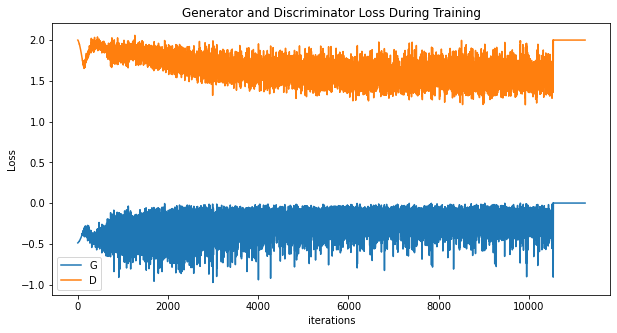

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(gen_losses,label="G")
plt.plot(disc_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

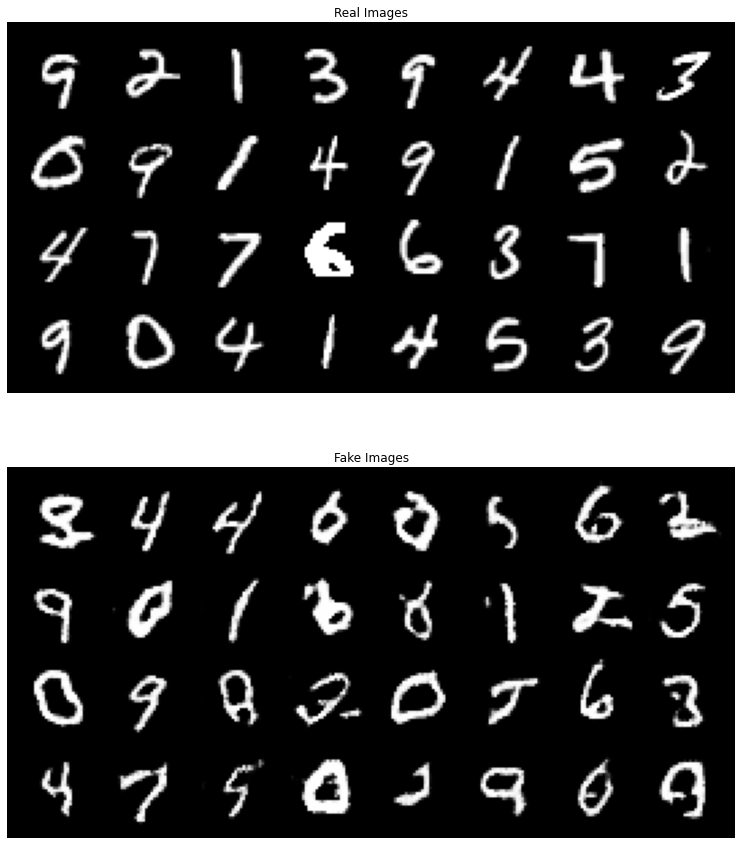

In [ ]:
real_batch = next(iter(train_loader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(2,1,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:32], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(2,1,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(vutils.make_grid(img_list[-1][:32] , padding=5, normalize=True),(1,2,0)))
plt.show()